## Data Filtering

Code Assistance Found Here:
https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python

In [1]:
#Import various modules
import numpy as np
from scipy import optimize  #Used to fit the regression
import matplotlib.pyplot as plt
import pandas as pd  #Used for general data manipulation
import seaborn as sns
import os
import statistics as stats
import math

In [2]:
data = pd.read_csv("./master_data/master_climate_data_all_variables.csv")

## Remove Years with Bad Data

In [3]:
## filter years with missing low flow/dry datat
# remove years 1999, 2000, 2003, 2006, 2010 2021
data = data[data['year'] != 2000] #bad flow data
data = data[data['year'] != 2003] #bad flow data
data = data[data['year'] != 2006] #bad flow data
data = data[data['year'] != 2010] #bad flow data
data = data[data['year'] != 2021] #bad flow data
data = data[data['year'] != 2023] #bad flow data
data.to_csv(r'./master_data/all_variables_bad_flow_removed.csv', index = False)
data

data_filtered = data #duplicate dataframe to filter
# Drop intermittency indicators to only look at predictors # 
data_filtered = data_filtered.drop(['days_no_flow_observed','no_flow_start_date_doy','flow_returns_doy','peak_discharge_to_dry_duration_days','dry_binary'], axis=1)
intermittency_indicators = data[['year','days_no_flow_observed','no_flow_start_date_doy','flow_returns_doy','peak_discharge_to_dry_duration_days','dry_binary']]

## Visualize Correlation Between Variables

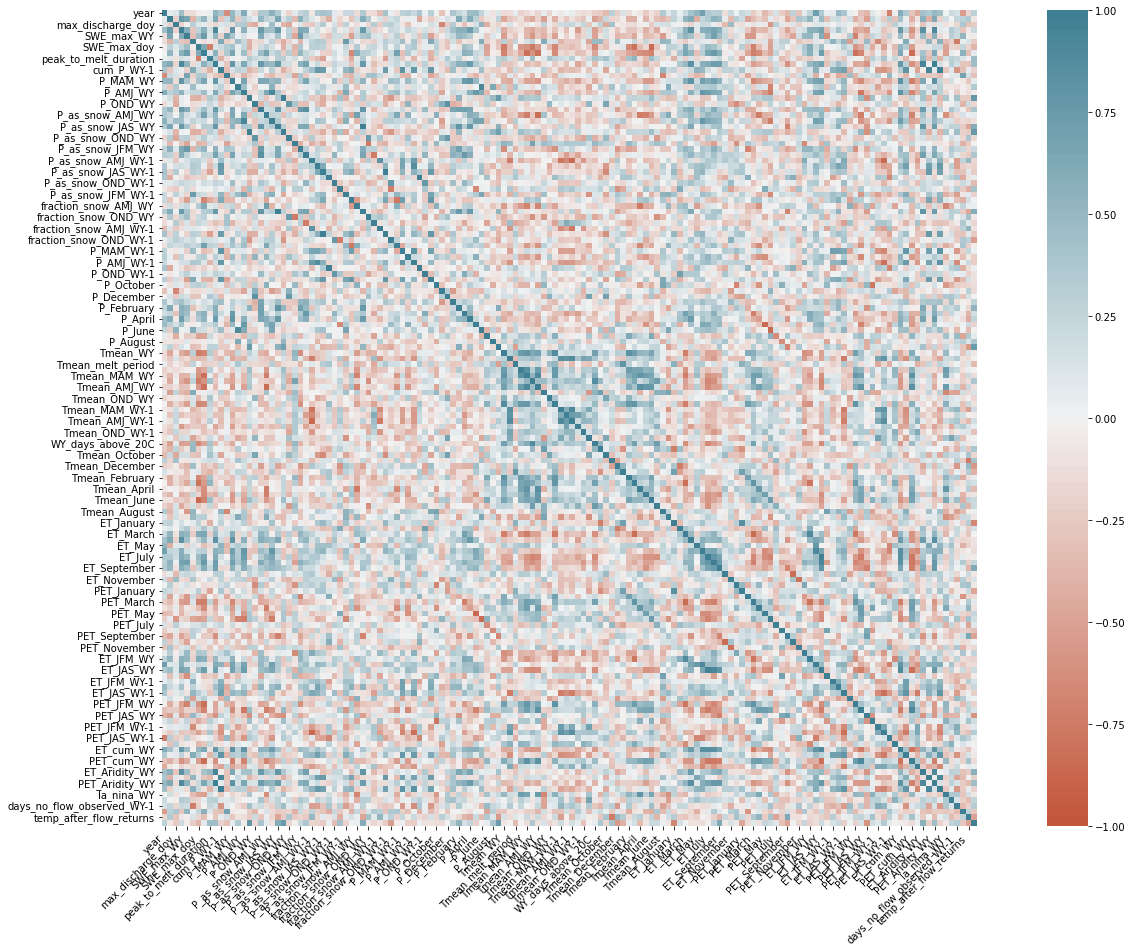

In [4]:
## unfiltered correlation matrix 
corr_matrix = data_filtered.corr(method = 'pearson', min_periods=1)

fig = plt.figure(figsize=(25,15))
ax=fig.add_subplot(1,1,1)
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

In [5]:
## Export Correlation Matrix Before Variables Filtered ##
corr_matrix.to_csv(r'./master_data/correlation_matrix_before_variable_filtering.csv', index = False)

## Complete Pearson Correlation to Remove Variables
Drop Variables by this Priority
1. Start with most correlated variables
2. Drop PET, Drop Monthly Values, Drop Seasons that are not OND, JFM, AMJ, JAS
3. Drop variables that represent multiple processes when correlated to variables of simple processes (ex: drop day_of_max_SWE when correlated to may_temp)
4. Drop the variable with the greater number of instances of correlation 
5. Drop antecedent variables when correlated with current year variables
6. Drop fractions of precip if correlated with precip value (ex: drop 'P_as_snow_OND_WY' if correlated to 'P_OND_WY')

In [6]:
## Drop Months ##
to_drop1 = ['P_January', 'P_February', 'P_March', 'P_April', 'P_May', 'P_June', 'P_July', 'P_August', 'P_September', 'P_October', 'P_November', 'P_December',\
           'ET_January', 'ET_February', 'ET_March', 'ET_April', 'ET_May', 'ET_June', 'ET_July', 'ET_August', 'ET_September', 'ET_October', 'ET_November', 'ET_December',\
           'Tmean_January', 'Tmean_February', 'Tmean_March', 'Tmean_April', 'Tmean_May', 'Tmean_June', 'Tmean_July', 'Tmean_August', 'Tmean_September', \
           'Tmean_October','Tmean_November', 'Tmean_December', ]
data_filtered.drop(to_drop1, axis=1, inplace=True)

## filter out all columns for MAM & JJA ##
data_filtered = data_filtered[data_filtered.columns.drop(list(data_filtered.filter(regex='MAM')))]
data_filtered = data_filtered[data_filtered.columns.drop(list(data_filtered.filter(regex='JJA')))]


## Drop Highly Correlated Pairs ## 
to_drop2 = ['ET_Aridity_WY', 'ET_Aridity_WY-1', 'total_acft_passed_WY', 'SWE_max_doy', 'ET_cum_WY', 'cum_P_WY', 'ET_cum_WY-1', 'cum_P_WY-1',\
           'Tmean_after_melt', 'Tmean_WY', 'Tmean_WY-1'] 
data_filtered.drop(to_drop2, axis=1, inplace=True)


## Drop Highly Correlated Pairs ## 
to_drop3 = ['P_as_snow_JAS_WY-1', 'fraction_snow_JAS_WY-1', 'fraction_snow_OND_WY', 'P_as_rain_JAS_WY', 'fraction_snow_OND_WY-1', 'fraction_snow_AMJ_WY-1', 'fraction_snow_AMJ_WY',\
           'P_as_rain_AMJ_WY', 'fraction_snow_JFM_WY-1', 'P_as_snow_JFM_WY', 'P_as_rain_JFM_WY', 'P_as_snow_OND_WY','P_as_rain_AMJ_WY-1']
           
data_filtered.drop(to_drop3, axis=1, inplace=True)

to_drop4 = ['P_JAS_WY-1','P_JFM_WY-1','P_as_snow_JAS_WY', 'max_discharge_Ls', 'ET_OND_WY-1', 'P_as_snow_AMJ_WY-1', 'P_as_snow_AMJ_WY', 'P_as_snow_OND_WY-1',\
           'P_as_snow_JFM_WY-1','fraction_snow_JAS_WY']#'ET_OND_WY-1' removed because missing 2001 and not correlated with any drying
data_filtered.drop(to_drop4, axis=1, inplace=True)

to_drop5 = ['PET_January', 'PET_February', 'PET_March', 'PET_April', 'PET_May', 'PET_June', 'PET_July', 'PET_August', 'PET_September', 'PET_October', 'PET_November', 'PET_December',\
    'PET_cum_WY', 'PET_Aridity_WY-1','PET_AMJ_WY-1', 'PET_JFM_WY','PET_Aridity_WY', 'PET_OND_WY-1', 'PET_AMJ_WY', 'full_melt_doy', 'precip_in_window']#PET removed because correlated with temp and less identifiable than temp, 'PET_OND_WY-1' removed because missing 2001 and not correlated with any drying
data_filtered.drop(to_drop5, axis=1, inplace=True)

In [7]:
## Correlation Matrix ##
corr_matrix = data_filtered.corr(method = 'pearson').abs()

## Identify Variables to Remove ##
corr_pairs = corr_matrix.unstack()
sorted_pairs = corr_pairs.sort_values()#kind="quicksort")
corr_results = pd.DataFrame(data=sorted_pairs, columns = ['correlation'])

# List Correlated Pairs ##
corr_results['correlation_abs'] = abs(corr_results['correlation'])
corr_results = corr_results[corr_results.correlation_abs != 1] # remove correlation == 1
corr_results_filtered  = corr_results[corr_results['correlation_abs'] >=0.75]
corr_results_filtered = corr_results_filtered.sort_values(by='correlation_abs', ascending=False)
display(len(corr_results_filtered)/2)
display(corr_results_filtered)

corr_results_filtered.to_csv(r'./master_data/correlated_pairs.csv', index = True)

0.0

,,correlation,correlation_abs


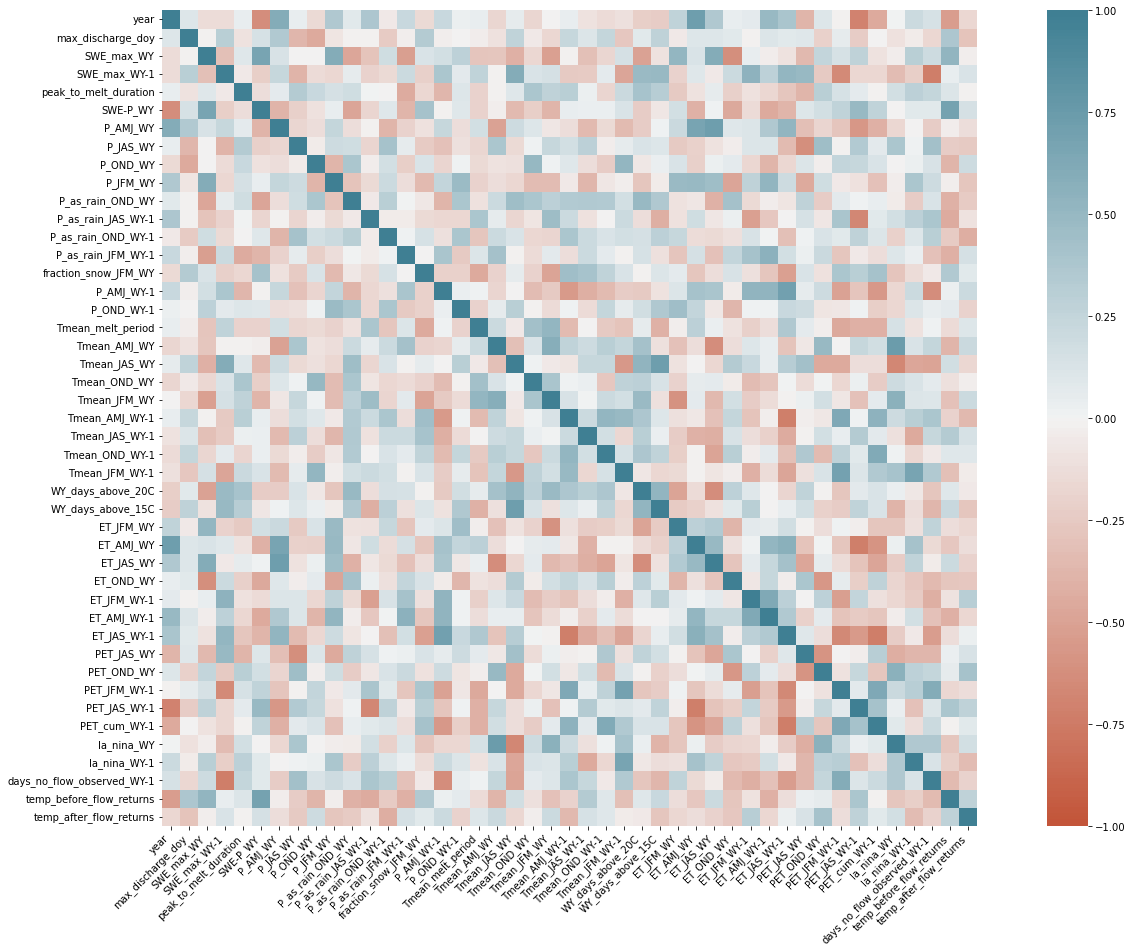

In [8]:
corr_matrix = data_filtered.corr(method = 'pearson').abs()

## Plot New Correlation Matrix ##
corr_matrix = data_filtered.corr(method = 'pearson', min_periods=1)

fig = plt.figure(figsize=(25,15))
ax=fig.add_subplot(1,1,1)
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

## Export

In [9]:
data = pd.concat([intermittency_indicators, data_filtered], axis=1)
data.to_csv(r'./master_data/filtered_indicator_and_predictor_variables.csv', index = False)
data

,year,days_no_flow_observed,no_flow_start_date_doy,flow_returns_doy,peak_discharge_to_dry_duration_days,dry_binary,year,max_discharge_doy,SWE_max_WY,SWE_max_WY-1,...,PET_JAS_WY,PET_OND_WY,PET_JFM_WY-1,PET_JAS_WY-1,PET_cum_WY-1,la_nina_WY,la_nina_WY-1,days_no_flow_observed_WY-1,temp_before_flow_returns,temp_after_flow_returns
1,2001,59.0,207.0,256.0,127.0,1.0,2001,80.0,20.6,28.8,...,59.654675,14.476735,18.229206,58.868595,15746.2930,-0.400,-1.025,16.0,11.10,10.36
2,2002,39.0,207.0,260.0,103.0,1.0,2002,104.0,27.8,20.6,...,57.038967,16.717836,17.667940,59.654675,13123.1300,0.250,-0.400,59.0,14.58,8.58
4,2004,14.0,224.0,230.0,141.0,1.0,2004,83.0,28.7,22.9,...,54.491550,18.354887,15.883489,59.409607,13136.1180,0.375,0.450,16.0,18.72,13.78
5,2005,44.0,217.0,253.0,78.0,1.0,2005,139.0,20.2,28.7,...,57.435380,14.458436,16.097878,54.491550,12804.1630,0.375,0.375,14.0,12.90,4.36
7,2007,76.0,188.0,261.0,117.0,1.0,2007,71.0,21.7,33.9,...,57.869480,17.066435,13.527661,57.984640,12677.1530,-0.025,-0.300,0.0,11.82,8.22
8,2008,51.0,217.0,264.0,90.0,1.0,2008,127.0,30.0,21.7,...,58.011383,15.943196,19.375078,57.869480,13374.2790,-1.000,-0.025,76.0,12.52,6.66
9,2009,0.0,NaN,NaN,NaN,0.0,2009,112.0,26.1,30.0,...,55.641937,16.406816,13.214120,58.011383,12460.7660,-0.200,-1.000,51.0,NaN,NaN
11,2011,0.0,NaN,NaN,NaN,0.0,2011,17.0,31.7,25.9,...,56.616974,15.762539,14.688388,56.294796,11814.8670,-1.000,0.275,0.0,NaN,NaN
12,2012,21.0,221.0,243.0,129.0,1.0,2012,92.0,22.1,31.7,...,58.276733,16.003061,13.182602,56.616974,11647.9390,-0.425,-1.000,0.0,13.78,11.24
13,2013,77.0,191.0,268.0,94.0,1.0,2013,97.0,14.4,22.1,...,55.603090,16.231367,15.957176,58.276733,12881.9980,-0.250,-0.425,21.0,8.60,4.20
